In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

# Local Imports
import inference.scheduler


In [30]:
from abc import ABC, abstractmethod
import torch
from tqdm import tqdm
from inference.distribution import Sampleable

class FieldTheory(Sampleable):
    def __init__(self, dim: int = 2, lattice_size: int = 256):
        self._dim = dim
        self._lattice_size = lattice_size

    @property
    def dim(self) -> int:
        return self._dim * self._lattice_size

    @abstractmethod
    def action(self, field: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - field: shape (batch_size, lattice_size, ..., lattice_size), with `dim` spatial dims

        Returns:
        - action: shape (batch_size,)
        """
        pass

    def sample(self,
               num_samples: int,
               num_steps: int = 1000,
               step_size: float = 0.1,
               device: torch.device = 'cpu') -> torch.Tensor:
        """
        Samples from exp(-S[φ]) using Metropolis-Hastings.

        Returns:
        - samples (torch.Tensor): Shape (num_samples, lattice_size, ..., lattice_size)
                                  with `dim` spatial dimensions.
        """
        lattice_shape = (self._lattice_size,) * self._dim
        shape = (num_samples,) + lattice_shape
        field = torch.randn(shape, device=device)

        for _ in tqdm(range(num_steps)):
            proposal = field + step_size * torch.randn_like(field)

            current_action = self.action(field)
            proposal_action = self.action(proposal)
            delta_S = proposal_action - current_action

            accept_prob = torch.exp(-delta_S)
            rand = torch.rand(num_samples, device=device)
            accept = rand < accept_prob

            field[accept] = proposal[accept]

        return field


class Phi4(FieldTheory):

    def __init__(self, beta: float, dim: int = 2, lattice_size: int = 256):
        """
        Initialize the phi^4 field theory with periodic boundary conditions.

        Args:
        - beta (float): The coupling constant.
        - dim (int): The dimension of the lattice.
        - num_lattice_points (int): The number of lattice points in each dimension.
        """
        super().__init__(dim, lattice_size)
        self._beta = beta
    
    def action(self, field: torch.Tensor) -> torch.Tensor:
        """
        Computes the action S[ϕ] = ∑_x [½(∂μϕ)^2 + ½m²ϕ² + λ/4 ϕ⁴].

        Args:
        - field (torch.Tensor): Shape (batch_size, dim, lattice_size)

        Returns:
        - action (torch.Tensor): Shape (batch_size,)
        """
        batch_size, dim, L = field.shape

        # Kinetic term: sum over spatial differences squared
        kinetic = torch.zeros(batch_size, device=field.device)

        for mu in range(dim):
            shifted = torch.roll(field, shifts=-1, dims=2)  # periodic BC
            diff = shifted - field
            kinetic += 0.5 * (diff ** 2).sum(dim=(1, 2))  # sum over dim and lattice

        # Potential term: ½ϕ² + λ/4 ϕ⁴
        phi2 = 0.5 * field ** 2
        phi4 = self._beta / 4.0 * field ** 4
        potential = (phi2 + phi4).sum(dim=(1, 2))  # sum over all lattice sites

        return kinetic + potential

100%|██████████| 1000/1000 [00:06<00:00, 153.15it/s]


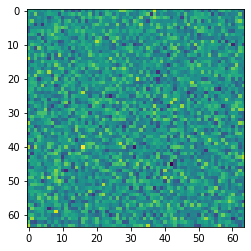

In [38]:
theory = Phi4(beta=10.0, dim=2, lattice_size=64)
samples = theory.sample(num_samples = 1, num_steps = 1000, step_size=0.1)
plt.imshow(samples[0])